In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

c:\users\agarg5\appdata\local\continuum\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
path = '../deeplearning1/nbs/data/instacart/instacart-picking-time-challenge-data/'
train = pd.read_csv(path+'train_trips.csv')
orders = pd.read_csv(path+'order_items.csv')
test = pd.read_csv(path+'test_trips.csv')


In [4]:
len(train)

117063

In [5]:
train.head()

,trip_id,shopper_id,fulfillment_model,store_id,shopping_started_at,shopping_ended_at
0,3119519,48539,model_1,6,9/1/2015 7:03,9/1/2015 7:30
1,3119513,3775,model_1,1,9/1/2015 7:04,9/1/2015 7:40
2,3119516,4362,model_1,1,9/1/2015 7:23,9/1/2015 7:41
3,3119792,47659,model_1,1,9/1/2015 7:29,9/1/2015 8:55
4,3119922,11475,model_1,1,9/1/2015 7:32,9/1/2015 9:01


In [223]:
len(orders)

2040286

In [260]:
xx = pd.DataFrame()
xx['test'] = pd.DatetimeIndex(['7:32 1/9/2015'])

In [261]:
xx.test

0   2015-01-09 07:32:00
Name: test, dtype: datetime64[ns]

In [11]:
orders.head()

,trip_id,item_id,department_name,quantity
0,3119513,368671,Produce,10.0
1,3120462,368671,Produce,10.0
2,3120473,368671,Produce,10.0
3,3121910,368671,Produce,6.0
4,3122332,368671,Produce,10.0


In [12]:
test.head()

,trip_id,shopper_id,fulfillment_model,store_id,shopping_started_at
0,4310899,60930,model_2,123,2015-11-16 07:00:12
1,4310904,59815,model_2,123,2015-11-16 07:00:12
2,4310907,60878,model_2,123,2015-11-16 07:00:13
3,4310911,60879,model_2,123,2015-11-16 07:00:13
4,4310328,66726,model_1,1,2015-11-16 07:01:08


In [276]:
s = X_test.shopper_id.unique()
xx = X_train.shopper_id.unique()
y_x = test.shopper_id.unique()
xxx = 0
y_xxx = 0
for ss in s:
    if (ss not in xx):
        xxx += 1
for ss in y_x:
    if (ss not in xx):
        y_xxx += 1
print('train={} , valid={}, test={}, new_in_valid={}, new_in_test={}'.format(len(xx),len(s),len(y_x),xxx,y_xxx))
## there are new shoppers as well

train=1484 , valid=1318, test=804, new_in_valid=22, new_in_test=150


In [6]:
total_quantity = orders['quantity'].groupby(orders.trip_id).sum()
count = orders.groupby('trip_id')['department_name'].nunique()
train['total_q'] = train.trip_id.map(total_quantity)
train['unique_items'] = train.trip_id.map(count)

In [7]:
list_items = orders['item_id'].groupby(orders.trip_id).apply(set)
list_dep = orders['department_name'].groupby(orders.trip_id).apply(set)


In [8]:
from datetime import datetime
start = train.shopping_started_at
end = train.shopping_ended_at
total_time = [datetime.strptime(end.iloc[i],"%m/%d/%Y %H:%M") - datetime.strptime(start.iloc[i],"%m/%d/%Y %H:%M") for i in range(len(train))]
train['total_time'] = [x.total_seconds() for x in total_time]

train['avg_time'] = train.total_time / train.total_q
avg_of_user = train.groupby('shopper_id')['avg_time'].mean()
# train.drop('avg_of_user', inplace=True, axis=1)

In [9]:
bb = []
cc = []
for i in range(len(train)):
    aa = datetime.strptime(start.iloc[i],"%m/%d/%Y %H:%M")
    bb.append(aa.hour)
    cc.append(aa.weekday())
train['hod'] = bb
train['dow'] = cc
train['list_items'] = train.trip_id.map(list_items)
train['list_dep'] = train.trip_id.map(list_dep)

In [7]:
avg_of_user.mean(),avg_of_user.std(),avg_of_user.min(),avg_of_user.max()

(184.19723544430795, 106.96862857605237, 39.960886571056065, 1950.0)

In [522]:
## find depts where unique items are less but total_time is higher than average
list = train[(train.total_time>3180) & (train.unique_items<2)].list_dep
a = {}
for idx in list:
    for dep in idx:
        if (dep in a.keys()):
            a[dep] = a[dep] + 1
        else:
            a[dep] = 1


In [523]:
sorted(a.items(), key=operator.itemgetter(1),reverse=True)


[('Alcohol', 38),
 ('Beverages', 22),
 ('Snacks', 9),
 ('Cat', 8),
 ('Popular', 7),
 ('Dog', 6),
 ('Personal Care', 6),
 ('Dairy & Eggs', 5),
 ('Produce', 5),
 ('Meat & Seafood', 4),
 ('Bakery', 4),
 ('Deli', 3),
 ('Household', 3),
 ('Frozen', 2),
 ('Smoothie Central', 2),
 ('Ice Cream Social!', 1),
 ('Pets', 1),
 ('Costumes', 1),
 ('Breakfast', 1),
 ('Thanksgiving', 1),
 ('Babies', 1),
 ('Dry Goods & Pasta', 1),
 ('Bulk', 1),
 ('Pantry', 1)]

In [8]:
(orders.groupby('department_name')['department_name'].count()).sort_values(ascending=False).head()

department_name
Popular         472826
Produce         236651
Dairy & Eggs    207164
Snacks          175607
Beverages       148023
Name: department_name, dtype: int64

In [10]:
## seems like alcohol and beverages category takes the most time
train['has_alcohol'] = ['Alcohol' in row for row in train.list_dep]
train['has_beverage'] = ['Beverages' in row for row in train.list_dep]
train['has_alcohol'] = train.has_alcohol.apply(int)
train['has_beverage'] = train.has_beverage.apply(int)

In [11]:
#Let's create some bins to divide on hours.
train['hourbins'] = pd.cut(train.hod, bins=4)
#Create categorical where day is Monday or Sunday
train['is_busy'] = np.where(train.dow.isin([1,6]), 1, 0 )

In [12]:
## calc reorder rate
reorders = orders.merge(train.loc[:,['trip_id','shopper_id']], left_on='trip_id', right_on = 'trip_id', how='left')
reordered_items = reorders.groupby(['shopper_id', 'item_id'])['trip_id'].count().to_frame()

In [79]:
reordered_items.head(10)

trip_id
shopper_id item_id         
52.0       489            1
           547            1
           1428           1
           1597           1
           1661           1
           1669           1
           1670           1
           2853           1
           3026           1
           3030           2

In [13]:
reordered_items = reordered_items.groupby('shopper_id')['trip_id'].sum() / reordered_items.groupby('shopper_id')['trip_id'].count()
reordered_factor = reordered_items.to_frame().rename(columns = {'trip_id': 'reorder_factor'})
reordered_factor.columns = ['reorder_factor']
reordered_factor.reset_index(inplace =True)

In [14]:
reordered_factor.head()

,shopper_id,reorder_factor
0,52.0,1.132127
1,64.0,1.034483
2,89.0,1.116862
3,95.0,1.144862
4,100.0,1.156822


In [15]:
train = train.merge(reordered_factor, left_on = 'shopper_id', right_on = 'shopper_id', how = 'left')

In [119]:
## user X total products ( test only )
#train['UP'] = train.shopper_id + (train.total_q*10000)

In [364]:
from sklearn.metrics import mean_squared_error, make_scorer, r2_score, mean_absolute_error

y_val = train.total_time
#As baseline I'll use the mean as predictor first. 
y_means = np.ones_like(y_val) * y_val.mean()
mean_absolute_error(y_val, y_means),r2_score(y_val,y_means),y_val.mean(),y_val.std()

(1090.3410749236432, 0.0, 2456.1769303708261, 1425.9587520105363)

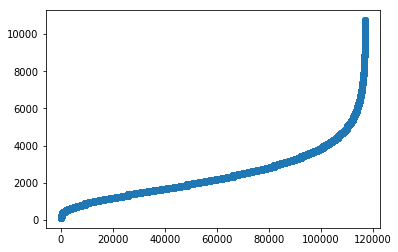

In [362]:
plt.scatter(list(range(len(train))),train.total_time.sort_values())
## this tells us that time higher then 4000 becomes too high

In [372]:
train[(train.total_time>4000) & (train.total_q<3)].list_dep

18444     {Produce, Bulk, Personal Care}
31212                          {Popular}
32971                           {Pantry}
42725                   {Bakery, Frozen}
42843                              {Dog}
45101                    {Personal Care}
52840                          {Produce}
68798                          {Alcohol}
72003                    {Personal Care}
95697            {Bakery, Personal Care}
112962                    {Dairy & Eggs}
Name: list_dep, dtype: object

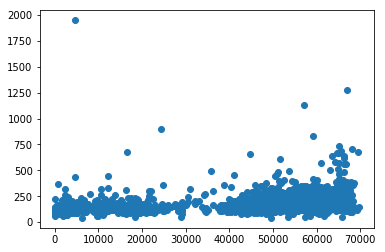

In [447]:
plt.scatter(avg_of_user.keys(),avg_of_user)

In [365]:
## since there are unseen users in the testset
## calc avg time to shop each product
orders['department_name'].unique()

array(['Produce', 'Snacks', 'Popular', 'Dairy & Eggs', 'Deli', 'Beverages',
       'Pantry', 'International', 'Canned Goods', 'Household',
       'Dry Goods & Pasta', 'Bakery', 'Meat & Seafood', 'Breakfast',
       'Frozen', 'Smoothie Central', 'Babies', 'Alcohol', 'Personal Care',
       "Valentine's Day Specials", ..., 'BBQ Favorites', 'Hanukkah',
       'Ready to Cook', "Buyers' Picks", 'Small Animal',
       'Vitamins & Supplements', 'Star Wars', 'Rosh Hashanah & Yom Kippur',
       'Reptile', 'Holiday', 'Fall Wine, Beer, & Spirits', 'Seasonal',
       'Flowers & Plants', 'Costumes', 'Holiday Turkeys',
       'Christmas & NYE Menu', 'Find it at Target', 'Holiday Butcher',
       'Hanukkah Menu', 'Thanksgiving Menu'], dtype=object)

In [13]:
## add features for shopper

shopper_total_orders = train.groupby('shopper_id')['total_q'].count()
shopper_total_orders.head()

shopper_id
52      65
64       4
89     115
95     116
100    137
Name: total_q, dtype: int64

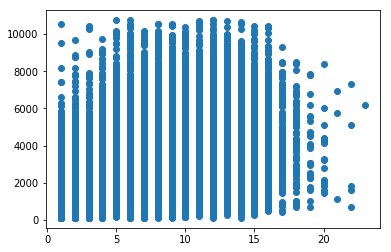

In [374]:
plt.scatter(train.unique_items,train.total_time)


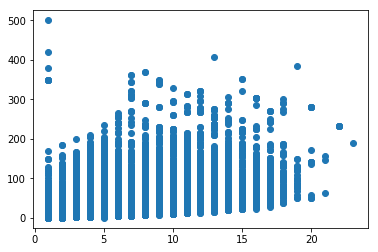

In [209]:
plt.scatter(train.unique_items,train.total_q)

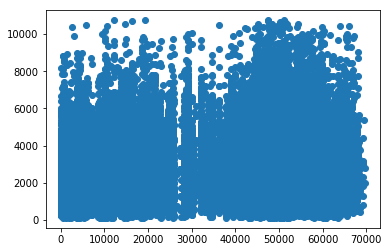

In [279]:
plt.scatter(train.shopper_id,train.total_time)

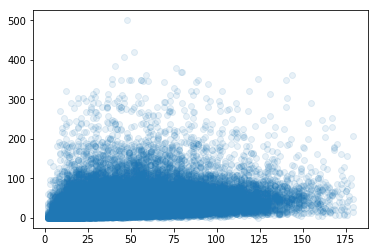

In [237]:
plt.scatter(train.total_time/60,train.total_q,alpha=0.1)

In [369]:
train.total_q.corr(train.total_time),train.unique_items.corr(train.total_time)

(0.39468737857154601, 0.48841997825192018)

In [368]:
train.head()

,trip_id,shopper_id,fulfillment_model,store_id,shopping_started_at,shopping_ended_at,total_q,unique_items,total_time,avg_time,hod,dow,list_items,list_dep,has_alcohol,has_beverage,hourbins,is_busy,reorder_factor
0,3119519,48539,model_1,6,9/1/2015 7:03,9/1/2015 7:30,39.0,11,1620.0,41.538462,7,1,"{1328769, 984065, 979208, 247571, 1322645, 132...","{Breakfast, Popular, Smoothie Central, Produce...",0,1,"(6.984, 11.0]",1,1.080522
1,3119513,3775,model_1,1,9/1/2015 7:04,9/1/2015 7:40,183.0,8,2160.0,11.803279,7,1,"{1889799, 1233034, 377611, 1233035, 1841682, 1...","{Popular, Deli, Produce, Dairy & Eggs, Pantry,...",0,1,"(6.984, 11.0]",1,1.129630
2,3119516,4362,model_1,1,9/1/2015 7:23,9/1/2015 7:41,9.0,5,1080.0,120.000000,7,1,"{1253061, 1247385, 1257572, 1253493, 1236397}","{Popular, Beverages, Snacks, Canned Goods, Hou...",0,1,"(6.984, 11.0]",1,1.938229
3,3119792,47659,model_1,1,9/1/2015 7:29,9/1/2015 8:55,92.0,10,5160.0,56.086957,7,1,"{974977, 1273219, 1256070, 558088, 3032714, 12...","{Popular, Breakfast, Produce, Pantry, Dairy & ...",0,1,"(6.984, 11.0]",1,1.210400
4,3119922,11475,model_1,1,9/1/2015 7:32,9/1/2015 9:01,186.0,7,5340.0,28.709677,7,1,"{1233408, 1235203, 1243525, 1262086, 1261717, ...","{Popular, Deli, Produce, Dairy & Eggs, Bakery,...",0,1,"(6.984, 11.0]",1,1.246304


In [16]:
from pandas_summary import DataFrameSummary
display(DataFrameSummary(orders).summary())

,trip_id,item_id,department_name,quantity
count,2.04029e+06,2.04029e+06,NaN,2.04029e+06
mean,3.75273e+06,1.03944e+06,NaN,1.61123
std,381355,563691,NaN,2.04583
min,3.11951e+06,8,NaN,-0.75
25%,3.41698e+06,503683,NaN,1
50%,3.73367e+06,1.21844e+06,NaN,1
75%,4.0808e+06,1.27945e+06,NaN,2
max,4.44084e+06,3.17774e+06,NaN,500
counts,2040286,2040286,2040286,2040286
uniques,128710,98479,86,210


In [210]:
train[(train.total_q>400) & (train.unique_items<5)]

,trip_id,shopper_id,fulfillment_model,store_id,shopping_started_at,shopping_ended_at,Unnamed: 6,t_time,total_q,list_items,list_dep,total_time,unique_items
20335,3304001,46213,model_2,3,9/15/2015 13:53,9/15/2015 14:45,0:52,3120,420.0,{247571},{Smoothie Central},3120.0,1
30224,3395197,49940,model_1,3,9/21/2015 18:30,9/21/2015 19:18,0:48,2880,500.0,{977198},{Popular},2880.0,1


In [446]:
train[(train.avg_time>2000) & (train.unique_items<5)].list_dep

1820                          {Dairy & Eggs}
22059                              {Popular}
31212                              {Popular}
32006                       {Meat & Seafood}
32631                              {Alcohol}
32971                               {Pantry}
42725                       {Bakery, Frozen}
42843                                  {Dog}
45101                        {Personal Care}
46128                               {Bakery}
48189     {Thanksgiving, Beverages, Alcohol}
51601                              {Produce}
52643                                 {Deli}
52840                              {Produce}
54577                                 {Bulk}
56145         {Dairy & Eggs, Meat & Seafood}
57352                         {Thanksgiving}
59786                              {Alcohol}
64672                                  {Dog}
64756                            {Beverages}
65800                         {Dairy & Eggs}
67246                        {Personal Care}
67966     

In [17]:
## Create features
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler

In [20]:
train.columns

Index(['trip_id', 'shopper_id', 'fulfillment_model', 'store_id',
       'shopping_started_at', 'shopping_ended_at', 'total_q', 'unique_items',
       'total_time', 'avg_time', 'hod', 'dow', 'list_items', 'list_dep',
       'has_alcohol', 'has_beverage', 'hourbins', 'is_busy', 'reorder_factor'],
      dtype='object')

In [160]:
cat_var_dict = { 'shopper_id' : 1556, 'store_id' : 10, 'hod' : 10,'dow' : 10,
                'fulfillment_model' : 10, 'has_alcohol' : 1, 'has_beverage' : 1, 'is_busy' : 1}
contin_vars = ['total_q','unique_items','reorder_factor']

In [171]:
import operator
cat_vars = [o[0] for o in sorted(cat_var_dict.items(), key=operator.itemgetter(1), reverse=True)]
cat_vars

['shopper_id',
 'fulfillment_model',
 'hod',
 'dow',
 'store_id',
 'has_beverage',
 'has_alcohol',
 'is_busy']

In [172]:
for v in contin_vars: train.loc[train[v].isnull(), v] = 0
for v in cat_vars: train.loc[train[v].isnull(), v] = ""

In [173]:
cat_maps = [(o, LabelEncoder()) for o in cat_vars]
contin_maps = [([o], StandardScaler()) for o in contin_vars]


In [174]:
cat_mapper = DataFrameMapper(cat_maps)
cat_map_fit = cat_mapper.fit(train)
cat_cols = len(cat_map_fit.features)
cat_cols

8

In [175]:
contin_mapper = DataFrameMapper(contin_maps)
contin_map_fit = contin_mapper.fit(train)
contin_cols = len(contin_map_fit.features)
contin_cols

c:\users\agarg5\appdata\local\continuum\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


3

In [176]:
cat_map_fit.transform(train)[0,:], contin_map_fit.transform(train)[0,:5]

c:\users\agarg5\appdata\local\continuum\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([666,   0,   0,   1,   3,   1,   0,   1], dtype=int64),
 array([ 0.5539905 ,  1.36147602, -1.03320366]))

In [177]:
cat_map_fit.transform(train)[:,1]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [178]:
[len(o[1].classes_) for o in cat_map_fit.features]

[1506, 2, 17, 7, 14, 2, 2, 2]

In [165]:
def cat_preproc(dat):
    return cat_map_fit.transform(dat).astype(np.int64)
def contin_preproc(dat):
    return contin_map_fit.transform(dat).astype(np.float32)

In [386]:
X_train, X_test, y_train, y_test = train_test_split(train, train.total_time, test_size=0.2)
cat_map_train = cat_preproc(X_train)
cat_map_valid = cat_preproc(X_test)
contin_map_train = contin_preproc(X_train)
contin_map_valid = contin_preproc(X_test)

c:\users\agarg5\appdata\local\continuum\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [387]:
cat_map_train.shape

(93650, 8)

In [388]:
## for xgboost
X_train = np.concatenate([cat_map_train, contin_map_train], axis=1)
X_valid = np.concatenate([cat_map_valid, contin_map_valid], axis=1)
X_train.shape

(93650, 11)

In [389]:
all_vars = cat_vars + contin_vars
all_vars

['fulfillment_model',
 'shopper_id',
 'hod',
 'dow',
 'store_id',
 'has_beverage',
 'has_alcohol',
 'is_busy',
 'total_q',
 'unique_items',
 'reorder_factor']

In [390]:
xgb_parms = {'learning_rate': 0.1, 'subsample': 0.6, 
             'colsample_bylevel': 0.6, 'silent': True, 'objective': 'reg:linear'}

In [391]:
#xgb_parms = {'learning_rate': 0.01, 'subsample': 1,'colsample_bylevel': 1, 'silent': True, 'objective': 'reg:linear'}

In [392]:
xdata = xgb.DMatrix(X_train, y_train, feature_names=all_vars)
xdata_val = xgb.DMatrix(X_valid, y_test, feature_names=all_vars)

In [393]:
## this is without feature engg
xgb_parms['seed'] = np.random.randint(0,1e9)
model = xgb.train(xgb_parms, xdata,1000)

In [398]:
model.eval(xdata_val),model.eval(xdata)

(b'[0]\teval-rmse:1074.483154', b'[0]\teval-rmse:883.437134')

In [395]:
len(X_valid),len(y_test)

(23413, 23413)

# NN

In [18]:
import keras
from keras.models import Model, Sequential
from keras.layers import *
from keras import initializers


Using TensorFlow backend.


In [ ]:
def cat_preproc(dat):
    return cat_map_fit.transform(dat).astype(np.int64)
def contin_preproc(dat):
    return contin_map_fit.transform(dat).astype(np.float32)
def split_cols(arr): return np.hsplit(arr,arr.shape[1])

In [281]:
cat_var_dict = { 'shopper_id' : 10, 'store_id' : 10, 'hod' : 10,'dow' : 10,
                'fulfillment_model' : 10, 'has_alcohol' : 1, 'has_beverage' : 1, 'is_busy' : 1}
contin_vars = ['total_q','unique_items','reorder_factor']

#cat_var_dict = { 'shopper_id' : 1556, 'store_id' : 10, 'hod' : 10,'dow' : 10,'fulfillment_model' : 10, 'has_alcohol' : 1, 'has_beverage' : 1, 'is_busy' : 1}
#contin_vars = ['total_q','unique_items','reorder_factor']

cat_vars = [o[0] for o in sorted(cat_var_dict.items(), key=operator.itemgetter(1), reverse=True)]
for v in contin_vars: train.loc[train[v].isnull(), v] = 0
for v in cat_vars: train.loc[train[v].isnull(), v] = ""

cat_maps = [(o, LabelEncoder()) for o in cat_vars]
contin_maps = [([o], StandardScaler()) for o in contin_vars]

cat_mapper = DataFrameMapper(cat_maps)
cat_map_fit = cat_mapper.fit(train)
cat_cols = len(cat_map_fit.features)

contin_mapper = DataFrameMapper(contin_maps)
contin_map_fit = contin_mapper.fit(train)
contin_cols = len(contin_map_fit.features)


X_train, X_test, y_train, y_test = train_test_split(train, train.total_time, test_size=0.2)
cat_map_train = cat_preproc(X_train)
cat_map_valid = cat_preproc(X_test)
contin_map_train = contin_preproc(X_train)
contin_map_valid = contin_preproc(X_test)

map_train = split_cols(cat_map_train) + split_cols(contin_map_train)
map_valid = split_cols(cat_map_valid) + split_cols(contin_map_valid)
np.shape(map_train)

c:\users\agarg5\appdata\local\continuum\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(11, 93650, 1)

In [145]:
map_train2 = np.reshape(map_train,(78432,11))

In [41]:
map_train[0]

array([[151],
       [304],
       [510],
       ..., 
       [502],
       [675],
       [319]], dtype=int64)

In [54]:
contin_map_fit

DataFrameMapper(default=False, df_out=False,
        features=[(['total_q'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['unique_items'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['reorder_factor'], StandardScaler(copy=True, with_mean=True, with_std=True))],
        input_df=False, sparse=False)

In [249]:
def my_init(scale):
    return lambda shape, name=None: initializers.uniform(shape, scale=scale, name=name)

In [250]:
def emb_init(shape, name=None): 
    return initializers.uniform(shape, scale=2/(shape[1]+1), name=name)

In [43]:
def cat_map_info(feat): return feat[0], len(feat[1].classes_)

In [180]:
cat_map_info(cat_map_fit.features[1])

('fulfillment_model', 2)

In [183]:
conts = [get_contin(feat) for feat in contin_map_fit.features]
conts

[(<tf.Tensor 'total_q_in_4:0' shape=(?, 1) dtype=float32>,
  <tf.Tensor 'total_q_d_4/BiasAdd:0' shape=(?, 1) dtype=float32>),
 (<tf.Tensor 'unique_items_in_4:0' shape=(?, 1) dtype=float32>,
  <tf.Tensor 'unique_items_d_4/BiasAdd:0' shape=(?, 1) dtype=float32>),
 (<tf.Tensor 'reorder_factor_in_1:0' shape=(?, 1) dtype=float32>,
  <tf.Tensor 'reorder_factor_d_1/BiasAdd:0' shape=(?, 1) dtype=float32>)]

In [282]:
def get_emb(feat):
    name, c = cat_map_info(feat)
    c2 = cat_var_dict[name]
    #c2 = (c+1)//2
    #if c2>50: c2=50
    inp = Input((1,), dtype='int64', name=name+'_in')
    # , W_regularizer=l2(1e-6)
 #   u = Flatten(name=name+'_flt')(Embedding(c, c2, input_length=1, init=emb_init)(inp))
    u = Flatten(name=name+'_flt')(Embedding(c, c2, input_length=1,embeddings_initializer='uniform')(inp))
    return inp,u

In [283]:
def get_contin(feat):
    name = feat[0][0]
    inp = Input((1,), name=name+'_in')
    #return inp, Dense(1, name=name+'_d', init=my_init(1.))(inp)
    return inp, Dense(1, name=name+'_d',kernel_initializer='random_uniform')(inp)

In [186]:
contin_inp = Input((contin_cols,), name='contin')
contin_out = Dense(contin_cols*10, activation='relu', name='contin_d')(contin_inp)
#contin_out = BatchNormalization()(contin_out)

In [334]:
from keras import metrics
embs = [get_emb(feat) for feat in cat_map_fit.features]
conts = [get_contin(feat) for feat in contin_map_fit.features]
contin_d = [d for inp,d in conts]
#x = merge([emb for inp,emb in embs] + [contin_out], mode='concat')
#x = merge([emb for inp,emb in embs] + contin_d, mode='concat')
x = concatenate([emb for inp,emb in embs] + contin_d)

x = Dropout(0.02)(x)
x = Dense(1000, activation="relu", kernel_initializer="uniform")(x)
x = Dense(10, activation="relu", kernel_initializer="uniform")(x)
x = Dense(500, activation="relu", kernel_initializer="uniform")(x)
x = Dropout(0.2)(x)
#x = Dense(1, activation='sigmoid')(x)
x = Dense(1,)(x)

#model = Model([inp for inp,emb in embs] + [contin_inp], x)
model = Model([inp for inp,emb in embs] + [inp for inp,d in conts], x)
model.compile('adam',loss='mean_absolute_error')
#model.compile('RMSprop', 'mean_absolute_error',metrics=['accuracy'])
#model.compile(Adam(), 'mse')

In [336]:
%%time 
hist = model.fit(map_train, y_train, batch_size=1024, epochs=100,verbose=2, validation_data=(map_valid, y_test))
#hist = model.fit(map_train, y_train, batch_size=1024, epochs=25,verbose=2)

Train on 93650 samples, validate on 23413 samples
Epoch 1/100
 - 2s - loss: 761.6768 - val_loss: 772.2603
Epoch 2/100
 - 2s - loss: 759.4672 - val_loss: 772.9330
Epoch 3/100
 - 2s - loss: 758.5626 - val_loss: 771.1347
Epoch 4/100
 - 2s - loss: 756.7625 - val_loss: 771.6765
Epoch 5/100
 - 2s - loss: 755.5675 - val_loss: 773.0298
Epoch 6/100
 - 2s - loss: 755.0407 - val_loss: 771.5717
Epoch 7/100
 - 2s - loss: 753.9554 - val_loss: 771.7627
Epoch 8/100
 - 2s - loss: 752.2332 - val_loss: 770.1176
Epoch 9/100
 - 2s - loss: 750.5799 - val_loss: 770.9118
Epoch 10/100
 - 2s - loss: 750.7298 - val_loss: 771.2828
Epoch 11/100
 - 2s - loss: 748.9046 - val_loss: 770.7555
Epoch 12/100
 - 2s - loss: 747.6667 - val_loss: 770.5024
Epoch 13/100
 - 2s - loss: 747.1106 - val_loss: 771.4863
Epoch 14/100
 - 2s - loss: 746.6612 - val_loss: 770.0438
Epoch 15/100
 - 2s - loss: 746.1140 - val_loss: 771.2295
Epoch 16/100
 - 2s - loss: 744.7215 - val_loss: 770.5667
Epoch 17/100
 - 2s - loss: 743.9465 - val_loss:

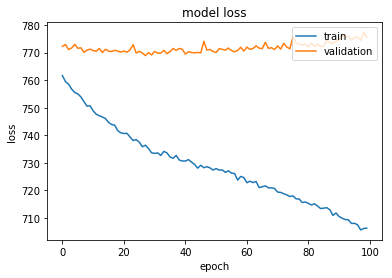

In [337]:
plot_train(hist,1)

In [135]:
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

In [235]:
from keras.models import load_model
model.save_weights('nn_718.h5')

ImportError: `save_weights` requires h5py.

In [257]:
predictions = model.predict(map_train)
mean_absolute_error(y_train,predictions),rmse(y_train,predictions)

790.52588801121749

In [278]:
predictions = model.predict(map_valid)
mean_absolute_error(y_test,predictions)

803.96187436084233

In [61]:
## calc pearson correlation
f_to_use = ['total_q','unique_items','shopper_id','hod','dow','store_id','has_alcohol','has_beverage','reorder_factor','is_busy']
## check co-relations with time
corr = {}
for f in f_to_use:
    key = f + ' vs time'
    corr[key] = pearsonr(train[f],train.total_time)[0]
corr

{'dow vs time': 0.038702353841445866,
 'has_alcohol vs time': 0.012319873356239242,
 'has_beverage vs time': 0.14117735738920922,
 'hod vs time': -0.022966896686758817,
 'is_busy vs time': 0.062973090103638801,
 'reorder_factor vs time': -0.021780563613276412,
 'shopper_id vs time': 0.056359415200679136,
 'store_id vs time': -0.058614691067299572,
 'total_q vs time': 0.39468737857154607,
 'unique_items vs time': 0.48841997825192002}

In [399]:
## Linear Regression 
#X = train.total_q.values.reshape(-1,1)
X = train[f_to_use]
y = train.total_time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
len(X_train),len(X_test)

(93650, 23413)

In [400]:
regr = LinearRegression()
regr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [401]:
# evaluate predictions
y_predict = regr.predict(X_train)
regr.score(X_test,y_test),mean_absolute_error(y_train, y_predict),r2_score(y_train, y_predict)

(0.28624044352788047, 881.44190271799016, 0.28687434030584591)

In [402]:
## XGB regression
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,colsample_bytree=1, max_depth=7)
#model = xgb.XGBRegressor(silent=1)
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.08, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.75)

In [403]:
from sklearn.metrics import explained_variance_score
predictions = model.predict(X_test)
print(explained_variance_score(predictions,y_test))


-0.590210332478


In [404]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
print(rmse(predictions,y_test))

1097.72532451


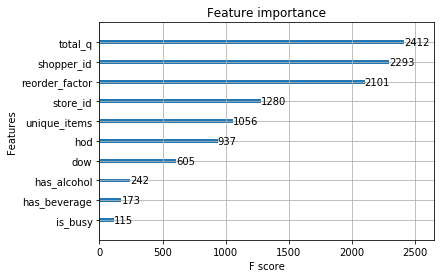

In [407]:
xgb.plot_importance(model)

In [410]:
## xgboost
xgb_parms = {'learning_rate': 0.1, 'subsample': 0.6, 
             'colsample_bylevel': 0.6, 'silent': True, 'objective': 'reg:linear'}
xdata = xgb.DMatrix(X_train, y_train, feature_names=f_to_use)
xdata_val = xgb.DMatrix(X_test, y_test, feature_names=f_to_use)


In [414]:
model = xgb.train(xgb_parms, xdata,1000)

In [415]:
model.eval(xdata_val)

b'[0]\teval-rmse:1077.515625'

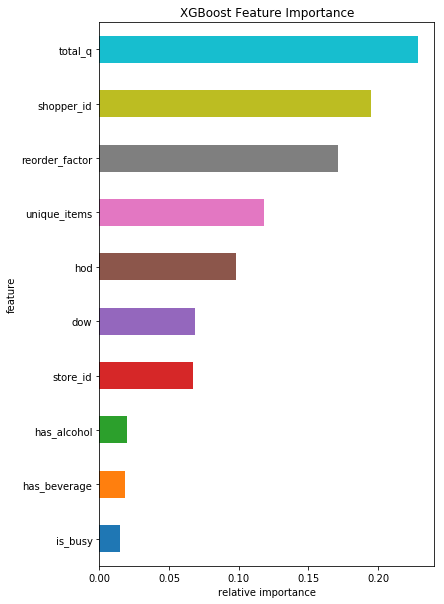

In [416]:
importance = model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance');

In [181]:
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 100  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

In [ ]:
## Submissions ( for syntax purposes only )
sub = pd.DataFrame(columns=['trip_id','shopping_time'])
idx = 0
for id in test.trip_id:
    b = regr.predict(id)
    v = " ".join(map(str, b))
    sub = sub.append({'trip_id':test.iloc[idx,0],'shopping_time':v},ignore_index=True)
    idx += 1
1

In [ ]:
sub = pd.DataFram()
inp = test.trip_id
out = regr

In [282]:
sub.head()

,trip_id,shopping_time
0,4310899,2512.27970739
1,4310904,2977.16358753
2,4310907,2349.57034934
3,4310911,2047.39582725
4,4310328,2186.86099129


In [284]:
from IPython.display import FileLink
sub.to_csv('prediction.csv',index=False)


In [ ]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [254]:
a = [10,10]
b = [2,2]
accuracy_score(a,b)

0.0